In [3]:
import pdb
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import pylab as plt
from astropy.wcs import WCS
from astropy.io import fits
import readcol
from utils import fast_sed_fitter
from utils import fast_double_sed_fitter
from utils import fast_Lir
from utils import fast_double_Lir
from utils import L_fun
from utils import L_fit
from utils import T_fun
from utils import T_fit
from utils import shift_twod
from utils import dist_idl
from utils import loggen
from utils import gauss_kern
from lmfit import Parameters, minimize, fit_report
from simstack import stack_libraries_in_redshift_slices
from skymaps import Skymaps
from skymaps import Field_catalogs

%matplotlib inline  

In [4]:
popcolor=['blue','red','green','orange','black','grey','chocolate','darkviolet','pink',
          'magenta','dodgerblue','lavender','blue','red','green','orange','black','grey',
          'chocolate','darkviolet','pink','magenta','dodgerblue','lavender']

In [5]:
conv_sfr = 1.728e-10 / 10**(.23)

In [6]:
#Define Redshift Bins
z_lo = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
z_hi = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_nodes = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_mid = (z_nodes[:-1] + z_nodes[1:])/2
nz = len(z_nodes) - 1

In [7]:
#Define Stellar Mass Bins
m_lo = np.array([8.5, 9.5,10.0,10.5,11.0])
m_hi = np.array([9.5,10.0,10.5,11.0,13.0])
m_nodes = np.array([8.5, 9.5,10.0,10.5,11.0,13.0])
m_mid = (m_nodes[:-1] + m_nodes[1:])/2
nm = len(m_nodes) - 1

In [30]:
#Decide which Maps to include
wv0 = np.array([1,1,1,1,1,1,1,1,1]) # This includes all maps
wv0 = np.array([0,0,1,1,1,0,1,1,0]) # 
wv0 = np.array([0,0,1,1,1,0,1,1,1]) # 
wv0 = np.array([0,1,1,1,1,0,1,1,0]) # 
indstack = np.where(wv0 == 1)

# Need to Edit next panel for your own use 
### Look for Maps below in www.astro.caltech.edu/viero/Jason/cosmos/

In [31]:
## Map Directories 

dir_spitzer_maps = '/data/maps/cosmos/cutouts/'
dir_spire_maps = '/data/maps/cosmos/cutouts/'
dir_pacs_maps = '/data/maps/cosmos/cutouts/'
dir_scuba_maps = '/data/maps/cosmos/cutouts/'
dir_aztec_maps = '/data/maps/cosmos/cutouts/'
dir_aztec_maps = '/data/maps/cosmos/cutouts/'

## Dictionary Names
library_keys =['mips24'
               ,'pacs_green'
               ,'pacs_red'
               ,'spire_PSW'
               ,'spire_PMW'
               ,'scuba_450'
               ,'spire_PLW'
               ,'scuba_850'
               ,'aztec'
              ]

wavelength=[24.,100,160,250,350,450,500,850,1100]
nwv = np.sum(wv0) 
fwhm =[6.32,7.4, 11.3,18.1, 25.2,7., 36.6,15.,18.]
efwhm=[6.32,6.7, 11.2,17.6, 23.9,7.8, 35.2,14.5,18.] # want to the measured effective FWHM later
color_correction=[1.25,23.58,23.82,1.018,0.9914,1e-3,0.95615,1e-3,1.0]
beam_area = [1.55e-09,1.,1.,1.,1.,1.62e-09,1.,5.6e-09,1.] #sr
beam_area = [1.55e-09,1.,1.,1.,1.,1.,1.,1.,1.] #sr

pixsize_suffix = '6.0_arcsec_pixels'

maps = [dir_spitzer_maps+'mips_24_GO3_sci_10.cutout.fits' 
        ,dir_pacs_maps+'pep_COSMOS_green_Map.DR1.sci.cutout.fits'
        ,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.sci.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PSW.signal.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PMW.signal.cutout.fits'
        ,dir_scuba_maps+'map450_new_header.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PLW.signal.cutout.fits'
        ,dir_scuba_maps+'map850_new_header.cutout.fits'
        #,dir_aztec_maps+'cosmos_jcmt_kscott20100925_new_header_6.0_arcsec_pixels_map.fits'
        ,dir_aztec_maps+'cosmos_jcmt_kscott20100925_new_header_map.cutout.fits'
       ]
noises = [dir_spitzer_maps+'mips_24_GO3_unc_10.cutout.fits' 
        ,dir_pacs_maps+'pep_COSMOS_green_Map.DR1.err.cutout.fits'
        ,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.err.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PSW.noise.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PMW.noise.cutout.fits'
        ,dir_scuba_maps+'map450_new_header_rms.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PLW.noise.cutout.fits'
        ,dir_scuba_maps+'map850_new_header_rms.cutout.fits'
        #,dir_aztec_maps+'cosmos_jcmt_kscott20100925_new_header_6.0_arcsec_pixels_noise.fits'
        ,dir_aztec_maps+'cosmos_jcmt_kscott20100925_new_header_map.cutout.fits'
       ]

# Reading Maps into Objects, and Objects into Dictionaries

In [32]:
sky_library={}

for t in indstack[0]:
    sky_library[library_keys[t]] = Skymaps(maps[t],noises[t],efwhm[t],color_correction=color_correction[t])
    sky_library[library_keys[t]].add_wavelength(wavelength[t])
    sky_library[library_keys[t]].add_fwhm(efwhm[t]) 
    if beam_area[t] != 1: sky_library[library_keys[t]].beam_area_correction(beam_area[t])

## Catalog Directories and Names
### Look for Maps below in www.astro.caltech.edu/viero/Jason/cosmos/

In [39]:
path_catalog = '/data/catalogs/cosmos/'
#Catalog must have the following (case sensitive) Columns:
# - RA
# - DEC
# - z_peak
# - LMASS
# - rf_U_V
# - rf_V_J
#ALPHA_J2000,DELTA_J2000,ZPDF,ZPDF_L68,ZPDF_H68,CLASS,MASS_MED,MASS_MED_MIN68,MASS_MED_MAX68
#file_catalog = 'COSMOS2015_Laigle+_v1.1.csv'
file_catalog = 'UVISTA_DR2_master_v2.1_USE.csv'

In [46]:
tbl = pd.read_table(path_catalog+file_catalog,sep=',')
#tbl['ID']=range(len(tbl['ALPHA_J2000']))
#tbl['ra']=tbl['ALPHA_J2000']
#tbl['dec']=tbl['DELTA_J2000']
#tbl['z_peak']=tbl['ZPDF']
#tbl['sfg']=tbl['CLASS']
tbl['LMASS']=tbl['lmass']

In [47]:
tbl.keys()

Index([u'ID', u'ra', u'dec', u'fuv', u'efuv', u'nuv', u'enuv', u'u', u'eu',
       u'uc', u'euc', u'B', u'eB', u'gp', u'egp', u'gc', u'egc', u'V', u'eV',
       u'rp', u'erp', u'rc', u'erc', u'NB711', u'eNB711', u'ip', u'eip', u'ic',
       u'eic', u'NB816', u'eNB816', u'zp', u'ezp', u'zc', u'ezc', u'IB427',
       u'eIB427', u'IB464', u'eIB464', u'IA484', u'eIA484', u'IB505',
       u'eIB505', u'IA527', u'eIA527', u'IB574', u'eIB574', u'IA624',
       u'eIA624', u'IA679', u'eIA679', u'IB709', u'eIB709', u'IA738',
       u'eIA738', u'IA767', u'eIA767', u'IB827', u'eIB827', u'Y', u'eY',
       u'NB118', u'eNB118', u'J', u'eJ', u'H', u'eH', u'Ks', u'eKs', u'ch1',
       u'ech1', u'ch2', u'ech2', u'ch3', u'ech3', u'ch4', u'ech4', u'mips24',
       u'emips24', u'ap_corr', u'z_spec', u'z_spec_cc', u'z_p', u'chi_p',
       u'odds', u'l68', u'u68', u'z_peak', u'q_z', u'lmass', u'rf_U_V',
       u'rf_V_J', u'LMASS'],
      dtype='object')

In [48]:
uVista = Field_catalogs(tbl)

In [ ]:
uVista.separate_sf_qt()

stacking spire_PSW
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green
stacking scuba_850


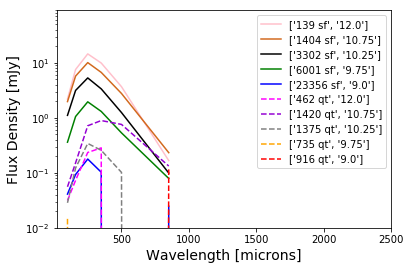

stacking spire_PSW
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green
stacking scuba_850


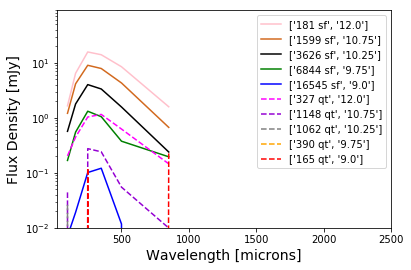

stacking spire_PSW
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green
stacking scuba_850


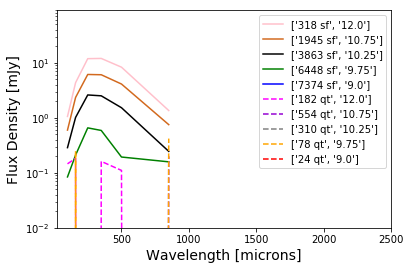

stacking spire_PSW
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green
stacking scuba_850


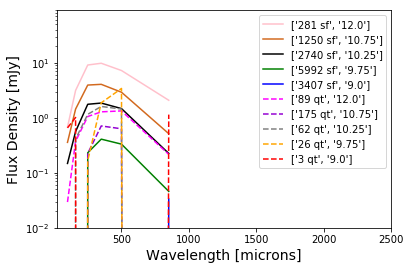

stacking spire_PSW
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green
stacking scuba_850


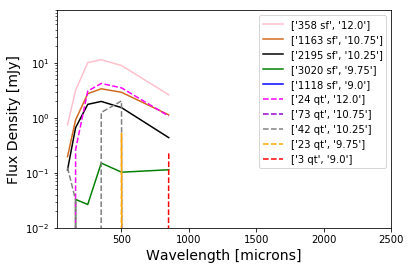

stacking spire_PSW
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green
stacking scuba_850


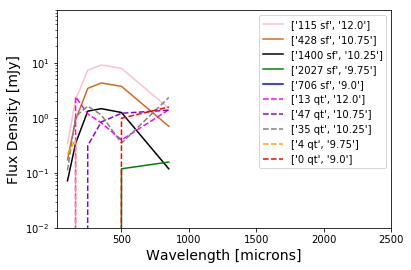

stacking spire_PSW
stacking pacs_red


In [ ]:
#Stack in redshift bins, with Layers divided by Stellar Mass and Star-Forming/Quiescent Galaxies
pop = ['sf','qt']
npop=2
all_stacked_fluxes = np.zeros([nwv,nz,nm,npop])
all_luminosity_temp = np.zeros([nz,nm,npop,2])

for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    uVista.get_sf_qt_mass_redshift_bins(zn,m_nodes)
    radec_m_z_p = uVista.subset_positions(uVista.id_z_ms)
    stacked_fluxes_  =  None
    n_sources_max = None
    
    stacked_fluxes = stack_libraries_in_redshift_slices(
        sky_library,
        radec_m_z_p)
    
    #pdb.set_trace()
    args = radec_m_z_p.keys()
    for iwv in range(nwv):
        stacked_fluxes_wv = stacked_fluxes[str(wavelength[indstack[0][iwv]])]
        for j in range(nm):
            for k in range(npop):
                arg = 'z_'+str(zn[0])+'-'+str(zn[1])+'__m_'+str(m_nodes[j])+'-'+str(m_nodes[j+1])+'_'+pop[k]
                all_stacked_fluxes[iwv,iz,j,k] = stacked_fluxes_wv[arg.replace('.','p').replace('-','_')].value
    
    #pdb.set_trace()
    #PLOT
    plt.figure()
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([20,510])
    plt.xlim([20,1800])
    plt.xlim([20,2500])
    plt.yscale('log')
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    ln=['','--']
    for k in range(npop):
        for j in range(nm)[::-1]: 
            arg = 'z_'+str(round(zn[0],3))+'-'+str(round(zn[1],3))+'__m_'+str(round(m_nodes[j],3))+'-'+str(round(m_nodes[j+1],3))+'_'+pop[k]
            ng = len(radec_m_z_p[arg.replace('.','p').replace('-','_')][0])
            plt.plot(np.array(wavelength)[indstack],1e3*all_stacked_fluxes[:,iz,j,k],ln[k],color=popcolor[npop*j+k],label=[str(ng)+' '+pop[k],str(m_mid[j])])
            plt.legend()
    plt.show()
    #pdb.set_trace()

In [ ]:
def nghack(a):
    b = a
    for i in range(len(a)):
        if a[i] < 0:
            b[i] = 1e-5
    return b

In [ ]:
for iwv in range(nwv):
    plt.figure()
    for j in range(nm):
        plt.yscale('log')
        plt.ylabel('Flux Density [mJy]',fontsize=14)
        plt.xlabel('Redshift',fontsize=14)
        plt.title('Star-Forming Galaxies, '+str(wavelength[indstack[0][iwv]]))
        plt.plot(z_mid,1e3*nghack(all_stacked_fluxes[iwv,:,j,0]),'o')
        plt.plot(z_mid,1e3*nghack(all_stacked_fluxes[iwv,:,j,0]))
    plt.show()

In [ ]:
for iwv in range(nwv):
    plt.figure()
    for j in range(nm):
        plt.yscale('log')
        plt.ylabel('Flux Density [mJy]',fontsize=14)
        plt.xlabel('Redshift',fontsize=14)
        plt.title('Star-Forming Galaxies, '+str(wavelength[indstack[0][iwv]]))
        plt.plot(z_mid,1e3*nghack(all_stacked_fluxes[iwv,:,j,0]),'o')
        plt.plot(z_mid,1e3*nghack(all_stacked_fluxes[iwv,:,j,0]))
    plt.show()

In [ ]:
for iwv in range(nwv):
    plt.figure()
    for j in range(nm):
        plt.yscale('log')
        plt.ylim([1e-2,9e1])
        plt.ylabel('Flux Density [mJy]',fontsize=14)
        plt.xlabel('Redshift',fontsize=14)
        plt.title('Quiescent Galaxies, '+str(wavelength[indstack[0][iwv]]))
        plt.plot(z_mid,1e3*(all_stacked_fluxes[iwv,:,j,1]),'o')
        plt.plot(z_mid,1e3*(all_stacked_fluxes[iwv,:,j,1]))
    plt.show()

In [ ]:
wvs = np.array(wavelength)[indstack]
luminosities = np.zeros([nz,nm])
temperatures = np.zeros([nz,nm])
luminosity_dictionary = {}
lumfit_dictionary = {}

for iz in range(nz):
    zn = z_nodes[iz:iz+2] 
    plt.ylim([9,14])
    for j in range(nm)[::-1]:
        flux_wv = (all_stacked_fluxes[:,iz,j,0] )   
        m = fast_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
        #sed = fast_sed(m, wvs)
        L_mod = fast_Lir(m, np.mean(zn))
        luminosities[iz,j] = L_mod.value
        temperatures[iz,j] = m['T_observed'].value * np.mean(zn)
        #print temperatures[iz,k] 
        
for j in range(nm)[::-1]:
    luminosity_dictionary['L_sed'+str(j)] = luminosities[:,j]
    luminosity_dictionary['T_sed'+str(j)] = temperatures[:,j]
        #print LIR.value
        #plt.plot(np.mean(zn),np.log10(LIR.value),'o')
    plt.plot(z_mid,np.log10(luminosity_dictionary['L_sed'+str(j)]))
        #plt.yscale('log')
        
    plt.ylabel('Luminosity [L_star]',fontsize=14)
    plt.xlabel('Redshift',fontsize=14)
#plt.show()